<a href="https://colab.research.google.com/github/jinalssem/sunny_git/blob/master/%EB%B9%84%ED%8A%B8%EC%BD%94%EC%9D%B8(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 패키지 수입 및 하이퍼 파라미터 지정

In [ ]:
# Matplotlib에서 한글을 보여줄 나눔폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
# 1. 패키지 수입
import pandas as pd
import numpy as np
import os
from time import time
import datetime
import platform
%matplotlib inline

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도

In [ ]:
from keras.layers import Dense
from keras.layers import LSTM, InputLayer, SimpleRNN
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split         # 사용하면 매우 편리

In [ ]:
# Google Drive Mount
from google.colab import drive, files
drive.mount('/content/drive',force_remount=True)       #  Mount를 안하면 /content/drive에 접근 불가 /content는 접근 가능

Mounted at /content/drive


In [ ]:
# 하이퍼 파라미터
MY_PAST = 5       # 과거 데이터 1년(12개월치의 데이터)
MY_HIDDEN = 256    # RNN 마스터 셀의 구조 규모, 과거 정보의 개수
MY_EPOCH = 200
MY_SHAPE = (MY_PAST, 1)  # 입력 데이터의 모양 정보, Keras RNN 요구 정보
DOLLAR_TO_WON = 1120
TRAIN_MODE = 0

### 2. 데이터 불러오기 및 선처리

In [ ]:
# GPU 사용 필요
# 데이터 준비
in_dir = '/content/drive/MyDrive/bitcoin/'
fname='BTC-USD.csv'
#fname='TSLA.csv'

fname=os.path.join(in_dir, fname)

raw = pd.read_csv(fname,
                usecols=['Date','Close'],
                parse_dates=True,
                index_col='Date')

In [ ]:
print('데이터 원본')
#print(type(raw))
# pd.datetime.now().date()
raw['Close'] = raw['Close']*DOLLAR_TO_WON
print(raw.tail(10))
print(raw.describe())

# 라인 플롯 출력
#plt.rcParams["figure.figsize"] = (14,4)

#plt.rcParams['lines.color'] = 'r'
#plt.rcParams['axes.grid'] = True 

#plt.plot(raw['Close'])   # plt.plot(raw)도 같은 결과 'Date'는 어디로?
#plt.show()

데이터 원본
                   Close
Date                    
2021-02-11  5.365845e+07
2021-02-12  5.320543e+07
2021-02-13  5.275818e+07
2021-02-14  5.473624e+07
2021-02-15  5.249503e+07
2021-02-16  5.496273e+07
2021-02-17  5.683562e+07
2021-02-18  5.815270e+07
2021-02-19  6.259471e+07
2021-02-20  6.256580e+07
              Close
count  2.349000e+03
mean   6.343767e+06
std    7.746598e+06
min    1.994754e+05
25%    5.043405e+05
50%    4.486190e+06
75%    9.770813e+06
max    6.259471e+07


In [ ]:
# [0, 1]] 정규화
scaler = MinMaxScaler()      # StandardScaler()과 비교
print(scaler)
scaled = scaler.fit_transform(raw)
print(type(scaled))

print('\n### 데이터 정규화 후')

# np->pd로 변환해보기
tmp = pd.DataFrame(scaled)
print(type(tmp))
print(tmp.head(10))
print(tmp.describe())


MinMaxScaler(copy=True, feature_range=(0, 1))
<class 'numpy.ndarray'>

### 데이터 정규화 후
<class 'pandas.core.frame.DataFrame'>
          0
0  0.005012
1  0.004422
2  0.003890
3  0.004143
4  0.003962
5  0.004022
6  0.004626
7  0.004400
8  0.004191
9  0.004062
                 0
count  2349.000000
mean      0.098474
std       0.124154
min       0.000000
25%       0.004886
50%       0.068703
75%       0.153399
max       1.000000


In [ ]:
# 시계열 데이터 분할
bundle =[]           # List
# 가장 중요
for i in range(len(raw)-(MY_PAST)):  # MY_PAST = 5 
    pick = scaled[i: i + MY_PAST + 1]
    bundle.append(pick)
    
print(type(bundle))    # List
print('### 데이터 묶음 결과')
print('한 묶음의 크기: ', len(bundle[0]))    # 5 + 1 = 6
print('총 데이터 묶음 개수: ',len(bundle))   # len(raw) - MY_PAST = 2329 - 5
print('첫번재 묶음: \n',bundle[0])
print('두번재 묶음: \n',bundle[1])


<class 'list'>
### 데이터 묶음 결과
한 묶음의 크기:  6
총 데이터 묶음 개수:  2344
첫번재 묶음: 
 [[0.00501222]
 [0.00442177]
 [0.00388966]
 [0.0041429 ]
 [0.00396191]
 [0.0040217 ]]
두번재 묶음: 
 [[0.00442177]
 [0.00388966]
 [0.0041429 ]
 [0.00396191]
 [0.0040217 ]
 [0.00462552]]


In [ ]:
# 리스트를 numpy로 전환 
bundle = np.array(bundle)
print(type(bundle))

# 데이터를 입력과 출력으로 분할
print('\n### 분할 전 데이터 모양:',bundle.shape)
X_data = bundle[:, 0:MY_PAST, :]   # 앞의 :은 행은 모두를 의미(2312개), 열은 0:MY_PAST(5):0~4까지 취한다. 마지막 콜론(:)은 생략 가능
#print(X_data)
print(X_data.shape)
Y_data = bundle[:, -1]      # -1은 맨 마지막 item
print(Y_data.shape)         # 2차원으로 변경됨

X_train = X_data
Y_train = Y_data

# 출력 후 확인
print('학습용 입력:', X_train.shape)
print('학습용 출력:', Y_train.shape)
print('X_train[0]: \n', X_train[0])
print('X_train[1]: \n', X_train[1])
print('Y_train[0]: ', Y_train[0])
print('Y_train[1]: ', Y_train[1])

<class 'numpy.ndarray'>

### 분할 전 데이터 모양: (2344, 6, 1)
(2344, 5, 1)
(2344, 1)
학습용 입력: (2344, 5, 1)
학습용 출력: (2344, 1)
X_train[0]: 
 [[0.00501222]
 [0.00442177]
 [0.00388966]
 [0.0041429 ]
 [0.00396191]]
X_train[1]: 
 [[0.00442177]
 [0.00388966]
 [0.0041429 ]
 [0.00396191]
 [0.0040217 ]]
Y_train[0]:  [0.0040217]
Y_train[1]:  [0.00462552]


In [ ]:
# 리스트 분할 연습
print('\n리스트 분할 연습')

l1=[]
for i in range(1,21):
  l1.append(i)

bu=list()
for i in range(len(l1)-(MY_PAST)):
    bu.append(l1[i: i+MY_PAST+1])

print('번들\n',bu)
bu = np.array(bu)
X1 = bu[:, 0:MY_PAST]   # 2차원 배열 분할
print(X1)
Y1 = bu[:,-1]
print(Y1)


리스트 분할 연습
번들
 [[1, 2, 3, 4, 5, 6], [2, 3, 4, 5, 6, 7], [3, 4, 5, 6, 7, 8], [4, 5, 6, 7, 8, 9], [5, 6, 7, 8, 9, 10], [6, 7, 8, 9, 10, 11], [7, 8, 9, 10, 11, 12], [8, 9, 10, 11, 12, 13], [9, 10, 11, 12, 13, 14], [10, 11, 12, 13, 14, 15], [11, 12, 13, 14, 15, 16], [12, 13, 14, 15, 16, 17], [13, 14, 15, 16, 17, 18], [14, 15, 16, 17, 18, 19], [15, 16, 17, 18, 19, 20]]
[[ 1  2  3  4  5]
 [ 2  3  4  5  6]
 [ 3  4  5  6  7]
 [ 4  5  6  7  8]
 [ 5  6  7  8  9]
 [ 6  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 12]
 [ 9 10 11 12 13]
 [10 11 12 13 14]
 [11 12 13 14 15]
 [12 13 14 15 16]
 [13 14 15 16 17]
 [14 15 16 17 18]
 [15 16 17 18 19]]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


### 3. 인공신경망 구현

In [ ]:
# 케라스 RNN은 2차원 입력만 허용

# RNN(LSTM) 구현
model = Sequential()

# 입력층과 LSTM 층을 동시에 추가
model.add(LSTM(units=MY_HIDDEN,   # MY_HIDDEN = 256
               input_shape=MY_SHAPE))         # LSTM(long short term memory)   MY_SHAPE = (MY_PAST, 1)
#model.add(SimpleRNN(units=MY_HIDDEN))        # LSTM으로 수정 후 비교, 이 문제에 한해 SimpleRNN이 조금 났다.
# 순방향 계산 : feed forward, 
# 역방향 계산(Back Propagation) : 가중치 보정
# Sigmoid(-1~1) : 경사하강법 처리를 위한 미분이 쉬움. MinMax로 인해 0~1 사이의 숫자가 나옴.

# 출력층 추가
model.add(Dense(units=1))  #activation=linear은 생략 가능

print('\nRNN 요약')
model.summary()
# Param의 개수는 역으로 확인이 불가


RNN 요약
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


### 4. 인공신경망 학습 및 평가

In [ ]:
# RNN 학습
model.compile(optimizer='adam',     # Learning rate(학습률)
             #loss='mape',
             loss='mse',        # mape와 비교, MSE(mean square error)
             # 생략metrics=['acc'])
             metrics=['acc'])
fname = 'bitcoin.h5'
fname = os.path.join(in_dir, fname)

if TRAIN_MODE:
  print('\n학습 시작')
  begin =time()
  model.fit(x=X_train,      # x: 입력
          y=Y_train,        # y: 정답
          epochs=MY_EPOCH,
          verbose=1)        # 2: 1보다 적은 결과를 보여줌, 0: 출력 안 함

  end = time()
  model.save_weights(fname)
  print('\n총 학습시간: {:.2f}초'.format(end-begin))
  print('학습 종료')
  print('TRAIN_MODE를 0으로 바꾸고 진행하세요')
  exit()

else:
  model.load_weights(fname)

In [ ]:
# RNN 평가
# 최근 6일 비트코인 시세 출력
print('\n최근 6일 비트코인 추세: ')
print(raw.tail(MY_PAST +1))
print(X_train[-1])



최근 6일 비트코인 추세: 
                   Close
Date                    
2021-02-15  5.249503e+07
2021-02-16  5.496273e+07
2021-02-17  5.683562e+07
2021-02-18  5.815270e+07
2021-02-19  6.259471e+07
2021-02-20  6.256580e+07
[[0.83813374]
 [0.87768325]
 [0.90769994]
 [0.92880854]
 [1.        ]]


In [ ]:

# LSTM으로 오늘 비트코인 시세 예측
# 맨 마지막 학습용 데이터 출력해서 확인
# 데이터 역정규화 필요
#print(X_train[-1])
#print(Y_train[-1])
#print(X_train[-1].shape)

X_ori = scaler.inverse_transform(X_train[-1])   # 역전환
print(X_ori)

print(Y_train[-1].shape)   # 1차원을 역전환하면 오류 발생(2차원으로 변환 필요)
tmp = Y_train[-1].reshape(1,1)  # 2차원으로 변환
print('오늘 비트코인 시세')

Y_ori = scaler.inverse_transform(tmp)   # 역정규화
print(Y_ori)

[[52495025.6208]
 [54962726.8736]
 [56835625.    ]
 [58152701.2528]
 [62594708.7472]]
(1,)
오늘 비트코인 시세
[[62565798.7472]]


### 5. 인공신경망 예측

In [ ]:
# RNN으로 오늘 시세 예측
# LSTM으로 내일 비트코인 시세 예측()
# 예측을 위해 인공신경망에 들어가는 데이터는 반드시 batch 정보를 추가해야 한다.
# pred = model.predict(X_train[-1])  # X_train[-1]은 3차원으로 3차원 필요, X_train[-1]은 2차원으로 오류 발생

tmp = X_train[-1].reshape(1,MY_PAST,1)  # batch 추가
#print(tmp.shape)
pred = model.predict(tmp)
pred = scaler.inverse_transform(pred)
print('RNN이 예측한 오늘 시세: ',pred)

RNN이 예측한 오늘 시세:  [[62710132.]]


In [ ]:
# 내일 시세 예측
tmp = raw.to_numpy()    # DataFrame -> Numpy
#print(type(raw))
#print(type(tmp))

tomorrow = tmp[len(tmp) - MY_PAST:]
print('내일 비트코인 시세 예측용 데이터')
post = tomorrow

내일 비트코인 시세 예측용 데이터


In [ ]:
# 체크해보면 폰트 개수가 늘어났다
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")
# 한번 프린트 해보자
print(nanum_font)

sys_font number: 48
nanum_font number: 31
['/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf', '/usr/share/fonts/truetype/nanum/NanumGothic.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf', '/usr/share/fonts/truetype/nanum/NanumBrush.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareEB.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundL.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicExtraBold.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoExtraBold.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoEco.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareL.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf', '/usr/share/fonts/truetype/nanum/NanumPen.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicLight.ttf', '/usr/share/fon

In [ ]:
# 현재 설정되어 있는 폰트 사이즈와 글꼴을 알아보자
!python --version
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
        
current_font()

font_path = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)

# fm._rebuild() 를 해줘야 system 에 추가 설치된 폰트를 matplotilb.font_manager 가 알아차리는 것으로 보인다.
# 우선 fm._rebuild() 를 해주고
fm._rebuild()

#앗~ 왜 마이너스 기호가 깨지지?
#mpl.rcParams['axes.unicode_minus'] = False 를 해줘야 한다
mpl.rcParams['axes.unicode_minus'] = False

Python 3.6.9
설정 폰트 글꼴: ['sans-serif'], 설정 폰트 사이즈: 10.0
NanumGothicCoding


[[54962726.8736]
 [56835625.    ]
 [58152701.2528]
 [62594708.7472]
 [62565798.7472]]


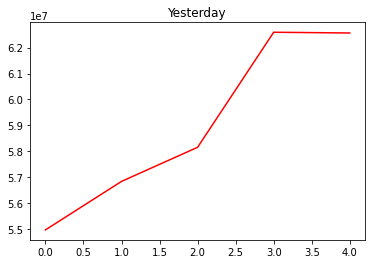

In [ ]:

# 그래프 출력
print(post)
plt.plot(tomorrow,'r')
plt.rc('font', family=font_name)
#plt.rc('font', family='Malgun Gothic')
# 글씨 선명하게 출력하는 설정
# %config InlineBackend.figure_format = 'retina'
plt.title('Yesterday')

plt.show()

In [ ]:
# 내일 예측용 데이터 정규화
#print(post)
tomorrow= scaler.fit_transform(post)

tomorrow=tomorrow.reshape(1,MY_PAST,1)
#print(tomorrow)

pred=model.predict(tomorrow)
#print(type(pred))
pred= scaler.inverse_transform(pred)
#print(type(pred))
print('내일 예측 시세', pred)


내일 예측 시세 [[62434120.]]


Today predict
[54962726.8736 56835625.     58152701.2528 62594708.7472 62565798.7472
 62434120.    ]


findfont: Font family ['NanumGothicCoding'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothicCoding'] not found. Falling back to DejaVu Sans.


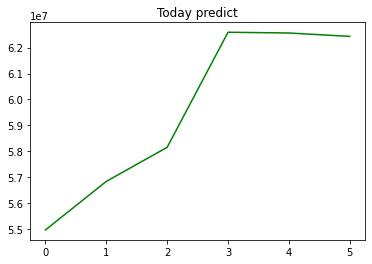

In [ ]:
print('Today predict')
post = np.append(post,pred)
#print(len(post))
print(post)
plt.plot(post,'g')
plt.title('Today predict')
plt.show()

In [ ]:
# 모레 예측용 데이터 정규화

post= np.delete(post,[0][0])
#print(len(post))

post = post.reshape(-1,1)
tmp= scaler.fit_transform(post)
#print(tmp)
tmp = tmp.reshape(1,MY_PAST,1)

pred = model.predict(tmp)
pred = scaler.inverse_transform(pred)

print('모레 예측값: ', pred)

모레 예측값:  [[62164850.]]


모레 예상 추세
[56835625.     58152701.2528 62594708.7472 62565798.7472 62434120.
 62164848.    ]


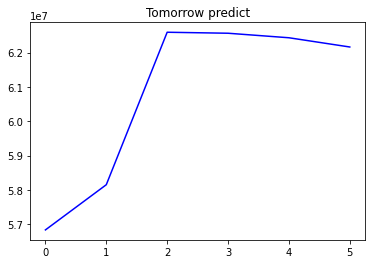

In [ ]:
print('모레 예상 추세')
post = np.append(post,pred)
#print(len(post))
print(post)
plt.plot(post,'b')
plt.title('Tomorrow predict')
plt.show()